## Dimensionality Reduction using Princial Component Analysis(PCA)

Compounds represented as Simplified Molecular Inpunt Line Entry System(SMILES) can be converted from their string format to numerical vector representations known as 'molecular fingerprints'. These fingerprints are typically 1024 to 2048 bits long with each bit representing a dimension. In this notebook, Principal Component Analysis(PCA) will be applied to the training data to obtain a new set of dimensions(also known as principal components). PCA is one of the most commonly used unsupervised machine learning algorithms for dimensionality reduction. By generating new principal components, it allows us to explain the variation in data using fewer dimensions.

In [34]:
import os
import pandas as pd
import numpy as np
import random
import pickle
import sklearn.ensemble
from sklearn.metrics import roc_auc_score, mean_squared_error, mean_absolute_error

from rdkit import Chem, DataStructs
import rdkit.Chem as rkc
import rdkit.Chem.AllChem as rkac
import rdkit.Chem.Scaffolds.MurckoScaffold as mrks
from rdkit.Chem import AllChem, MACCSkeys, PandasTools
from rdkit.Avalon import pyAvalonTools

import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
# provide path to the dataset
path = 'Data/DRD2_clean_data.csv'

df = pd.read_csv(path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6770 entries, 0 to 6769
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   canonical  6770 non-null   object 
 1   pChEMBL    6770 non-null   float64
dtypes: float64(1), object(1)
memory usage: 105.9+ KB


In [36]:
df.head()

,canonical,pChEMBL
0,CCCSc1nnc(-c2ccccc2)n1C,3.74
1,Cc1ccc(CNCC2(F)CCN(C(=O)c3cc(Br)cs3)CC2)nc1,4.00
2,COc1ccccc1N1CCC2(CCNCC2)CC1,4.00
3,Cl.NCCc1ccc(O)c(O)c1,4.00
4,Cn1c(SCCCN2CCCCC2)nnc1-c1ccccc1,4.01


In [37]:
X = df['canonical']

# note that the target label that we are trying to predic are pChEMBL values in this case
y = df['pChEMBL']

In [38]:
# divide data into train and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [39]:
print(X_train.size)
print(X_test.size)

5754
1016


## Creating Circular Fingerprints

In [40]:
# convers a list of SMILEs to a list of mols
def smi_to_mols(smi_list):
    mols_list = [Chem.MolFromSmiles(smile) for smile in smi_list]
    return mols_list


# returns morgan fingerprints as a 2D array for a list of SMILE strings
def get_morgan_fingerprints(smi_list, size, radius, useFeatures, useCounts=True):
        mols = smi_to_mols(smi_list)
        fps = [AllChem.GetMorganFingerprint(mol, radius, useCounts=useCounts, useFeatures=useFeatures) for mol in mols]
        fps_arr = np.zeros((len(fps), size), np.int32)
        for i, fp in enumerate(fps):
            for index, value in fp.GetNonzeroElements().items():
                n_index = index % size
                fps_arr[i, n_index] += int(value)
        return fps_arr 

In [41]:
# conver series to a list
X_train_list = X_train.tolist()
X_test_list = X_test.tolist()

In [42]:
# get fingerprints for training and test data
X_train_arr = get_morgan_fingerprints(X_train_list, size=1024, radius=3, useFeatures=True, useCounts=True)
X_test_arr = get_morgan_fingerprints(X_test_list, size=1024, radius=3, useFeatures=True, useCounts=True)

In [43]:
# check the number of dimensions
X_train_arr.shape

(5754, 1024)

## Dimensionality Reduction with PCA

In [44]:
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

In [45]:
# apply scaling to train and test data
sc = StandardScaler()
X_train = sc.fit_transform(X_train_arr)
X_test = sc.transform(X_test_arr)

In [60]:
# calculates the amount of variation explained by a each number of components
def get_component_performance(fps_arr):
    result = []
    for n in tqdm(range(2,302)):
        pca = PCA(n_components = n)
        cmpts = pca.fit_transform(fps_arr)
        variance = np.sum(pca.explained_variance_ratio_)
        result.append([n, variance])
    return result


In [61]:
results = get_component_performance(X_train)

100%|██████████| 300/300 [06:47<00:00,  1.36s/it]


In [62]:
# create a df to store the amount of variance explaind by all number of components
results_df = pd.DataFrame(results, columns = ['Components','Variance'])

In [63]:
# print results df for explained variance
results_df.tail()

,Components,Variance
295,297,0.786605
296,298,0.787529
297,299,0.788452
298,300,0.789437
299,301,0.790210


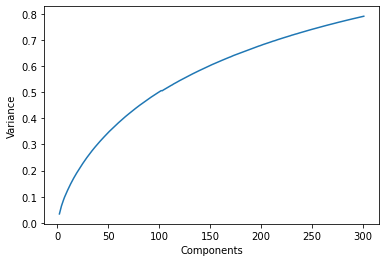

In [64]:
ax = sns.lineplot(data = results_df, x = 'Components', y = 'Variance')

In [65]:
# fit the PCA using train data
pca = PCA(n_components = 310)
train_cmpts = pca.fit_transform(X_train)

In [66]:
# transform the test data
test_cmpts = pca.transform(X_test)

In [67]:
print(train_cmpts.shape)
print(test_cmpts.shape)

(5754, 310)
(1016, 310)


## Support Vector Regressor

In [68]:
import sklearn.svm

# create an instance of SVR
sv = sklearn.svm.SVR()

# create a grid for cross validation
kernel = ['poly','rbf','sigmoid']
gamma = ['scale','auto']
C = [float(x) for x in np.linspace(start = 0.02, stop = 50, num = 100)]

sv_grid = {'kernel': kernel,
        'gamma': gamma,
        'C': C}
print(sv_grid)

{'kernel': ['poly', 'rbf', 'sigmoid'], 'gamma': ['scale', 'auto'], 'C': [0.02, 0.5248484848484848, 1.0296969696969696, 1.5345454545454542, 2.039393939393939, 2.544242424242424, 3.0490909090909084, 3.5539393939393933, 4.058787878787878, 4.563636363636363, 5.0684848484848475, 5.573333333333332, 6.078181818181816, 6.583030303030301, 7.087878787878786, 7.592727272727271, 8.097575757575756, 8.60242424242424, 9.107272727272726, 9.61212121212121, 10.116969696969695, 10.62181818181818, 11.126666666666665, 11.63151515151515, 12.136363636363633, 12.641212121212119, 13.146060606060603, 13.650909090909089, 14.155757575757573, 14.660606060606058, 15.165454545454542, 15.670303030303028, 16.175151515151512, 16.679999999999996, 17.18484848484848, 17.689696969696968, 18.19454545454545, 18.699393939393936, 19.20424242424242, 19.709090909090907, 20.21393939393939, 20.718787878787875, 21.22363636363636, 21.728484848484843, 22.23333333333333, 22.738181818181815, 23.2430303030303, 23.747878787878783, 24.252

In [69]:
# begin the cross validation process
from sklearn.model_selection import RandomizedSearchCV

sv_random = RandomizedSearchCV(estimator = sv, param_distributions = sv_grid, n_iter = 20,
                               cv = 3, verbose = 2)

sv_random.fit(train_cmpts, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] kernel=rbf, gamma=auto, C=33.844848484848484 ....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... kernel=rbf, gamma=auto, C=33.844848484848484, total=   7.4s
[CV] kernel=rbf, gamma=auto, C=33.844848484848484 ....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s remaining:    0.0s


[CV] ..... kernel=rbf, gamma=auto, C=33.844848484848484, total=   7.5s
[CV] kernel=rbf, gamma=auto, C=33.844848484848484 ....................
[CV] ..... kernel=rbf, gamma=auto, C=33.844848484848484, total=   7.3s
[CV] kernel=sigmoid, gamma=scale, C=28.291515151515146 ...............
[CV]  kernel=sigmoid, gamma=scale, C=28.291515151515146, total=   8.5s
[CV] kernel=sigmoid, gamma=scale, C=28.291515151515146 ...............
[CV]  kernel=sigmoid, gamma=scale, C=28.291515151515146, total=   9.2s
[CV] kernel=sigmoid, gamma=scale, C=28.291515151515146 ...............
[CV]  kernel=sigmoid, gamma=scale, C=28.291515151515146, total=   9.1s
[CV] kernel=sigmoid, gamma=auto, C=5.573333333333332 .................
[CV] .. kernel=sigmoid, gamma=auto, C=5.573333333333332, total=   8.7s
[CV] kernel=sigmoid, gamma=auto, C=5.573333333333332 .................
[CV] .. kernel=sigmoid, gamma=auto, C=5.573333333333332, total=   8.4s
[CV] kernel=sigmoid, gamma=auto, C=5.573333333333332 .................
[CV] .

[CV] .... kernel=poly, gamma=auto, C=18.699393939393936, total=  12.7s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  7.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, shrinking=True,
                                 tol=0.001, verbose=False),
                   iid='warn', n_iter=20, n_jobs=None,
                   param_distributions={'C': [0.02, 0.5248484848484848,
                                              1.0296969696969696,
                                              1.5345454545454542,
                                              2.039393939393939,...
                                              10.116969696969695,
                                              10.62181818181818,
                                              11.126666666666665,
                                              11.63151515151515,
                                              12.136363636363633,
   

In [70]:
sv_random.best_params_

{'kernel': 'rbf', 'gamma': 'scale', 'C': 7.592727272727271}

In [71]:
params = sv_random.best_params_

In [72]:
# create a final model with the best parameters
sv_final = sklearn.svm.SVR(**params)

sv_final.fit(train_cmpts, y_train)

SVR(C=7.592727272727271, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='scale', kernel='rbf', max_iter=-1, shrinking=True, tol=0.001,
    verbose=False)

In [73]:
# check results with the test data

y_pred_test = sv_final.predict(X= test_cmpts)
MSE = mean_squared_error(y_test, y_pred_test)
MAE = mean_absolute_error(y_test, y_pred_test)
print("Mean Squared Error: " + str(MSE))
print("Mean Absolute Error: " + str(MAE))

Mean Squared Error: 0.4230018419648803
Mean Absolute Error: 0.4835606755225088


## Save final models

In [ ]:
with open("models/DRD2_pChEMBL_pca.pkl", "wb") as f:
    pickle.dump(pca, f)
    
with open("models/DRD2_pChEMBL_sv_w_pca.pkl", "wb") as f:
    pickle.dump(sv_final, f)